#the Problem description 
the eyes diseases can be describe to us addional informations about other diseaes may patient has in his sitution , we try to build a model based on convolution neural network to predict the disease from external eye facial and recommened what type of diseae is has from expert people .

In [ ]:
from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed
#set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform
from tensorflow import keras
from sklearn.utils import shuffle
#from sklearn.metrics import confusion_matrix
#from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive, files

drive.mount('/drive')

Mounted at /drive


# Check Samples dataset and collecting 
* fisrt probelm we had . it was the data to use in our task : \\
the data wasn't avaialble from comfirme Organization because of the authourization , here we decide to use automated web scapring data to collect sample from search engine like " Google " , and we know this technics has some issues to be consider we will list them 
1. unbalnace dataset 
2. high varainces between classes collected 
3. random scaraped images based one queries 
* solution to fixed the problem we decribed 
1. we did the maunally deleted the unnecessary images from each folder's class 
2. we used augementation technic to balance the dataset and change images to multi-shape repesentation to make data be more usefull to feed into model 
3. for solve the variance we try to use augmemtation layer to random let model learn from diffrent postional at data distrution 
* here we will display few samples 
* convert dataset from directory setup into dataFrame  

In [ ]:
os.listdir('/drive/My Drive/Fouzia/dataset/train/augment_images')

FileNotFoundError: ignored

In [ ]:
folder_list = os.listdir('/drive/My Drive/Fouzia/dataset/train/augment_images')

total_images = 0

for folder in folder_list:
  #/drive/My Drive/dataset/train/
    path = '/drive/My Drive/Fouzia/dataset/train/augment_images/' + str(folder)
    images_list = os.listdir(path)
    num_images = len(images_list)
    
    total_images = total_images + num_images
    print(str(folder) + ':' + ' ' + str(num_images))
    
print('\n')
print('Total Images: ', total_images)
    

normal_eye: 90
stye_eye: 167
jaundice_eye: 126
uveitis_eye: 54
pink_eye: 60


Total Images:  497


In [ ]:
all_images_dir = 'all_images'
os.mkdir(all_images_dir)

In [ ]:
import shutil
folder_list = os.listdir('/drive/My Drive/Fouzia/dataset/train/augment_images/')

for folder in folder_list:
    
    # create a path to the folder
    path = '/drive/My Drive/Fouzia/dataset/train/augment_images/' + str(folder)

    # create a list of all files in the folder
    file_list = os.listdir(path)

    # move the 0 images to all_images_dir
    for fname in file_list:

        # source path to image
        src = os.path.join(path,fname)
        
        # Change the file name because many images have the same file name.
        # Add the folder name to the existing file name.
        new_fname = str(folder) + '_' + fname
        
        # destination path to image
        dst = os.path.join(all_images_dir,new_fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
# Check how many images are in all_images_dir.
# Should be 5539.

len(os.listdir('all_images'))

497

# labaling datasetv by use ONe-Hot-encoding 
since that data was collected from internt 
on problem has to be tell is the all the images may have the same features repesenrtation . here we propose to use one-hot-encodng to make each class has diffrent vector represeation by encoding lables . and this we will allow us to use other technic in hypre-paramters to make model learn from all diffrent data distrubtion 

In [ ]:
# Get a list of all images in the all_images_dir folder.
image_list = os.listdir('all_images')

# Create the dataframe.
df_file = pd.DataFrame(image_list, columns=['image_id'])
def extract_target(x):
    # split into a list
    a = x.split('_')
    #b = y.split('_')
    # the target is the first index in the list
    target = a[0]

    #Labels=b[0:4]
    
    return target

# create a new column called 'target'
df_file['Classes'] = df_file['image_id'].apply(extract_target)
#df_data['DiabeticRetinopathy','Myopia','Glaucoma','Normal'].apply(extract_target)
dum_df = pd.get_dummies(df_file.Classes, prefix=None )
#df_data = df_data.join(dum_df)
dum_df = pd.get_dummies(df_file.Classes, prefix=None )
df_data =df_file.join(dum_df)

In [ ]:
dum_df = pd.get_dummies(df_file.Classes, prefix=None )
dum_df.head(10)

,jaundice,normal,pink,stye,uveitis
0,0,0,0,1,0
1,1,0,0,0,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,0,0,1,0
5,0,1,0,0,0
6,0,0,1,0,0
7,0,0,0,1,0
8,0,0,0,1,0
9,0,1,0,0,0


In [ ]:
df_data =df_file.join(dum_df)
df_data.head(15)

,image_id,Classes,jaundice,normal,pink,stye,uveitis
0,stye_eye_stye_eye_original_image_88.jpg_88d678...,stye,0,0,0,1,0
1,jaundice_eye_jaundice_eye_original_image_16.jp...,jaundice,1,0,0,0,0
2,stye_eye_stye_eye_original_image_14.jpg_3cc8f2...,stye,0,0,0,1,0
3,normal_eye_normal_eye_original_image_34.jpg_85...,normal,0,1,0,0,0
4,stye_eye_stye_eye_original_image_60.jpg_9b163b...,stye,0,0,0,1,0
5,normal_eye_normal_eye_original_image_10.jpg_a4...,normal,0,1,0,0,0
6,pink_eye_pink_eye_original_image_37.jpg_81314d...,pink,0,0,1,0,0
7,stye_eye_stye_eye_original_image_26.jpg_360f31...,stye,0,0,0,1,0
8,stye_eye_stye_eye_original_image_15.jpg_27801b...,stye,0,0,0,1,0
9,normal_eye_normal_eye_original_image_9.jpg_e85...,normal,0,1,0,0,0


In [ ]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=plt.imread(file)
            ax[i, j].imshow(im,cmap=None,)
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

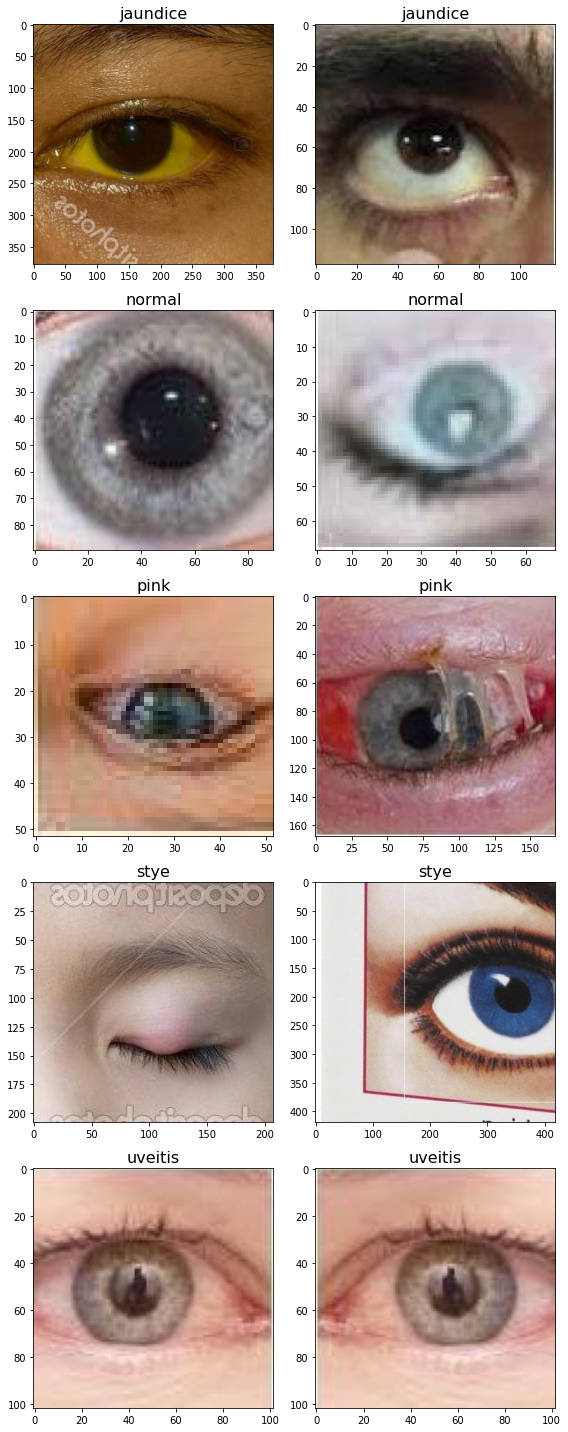

In [ ]:
IMAGE_PATH = 'all_images/'
draw_category_images('Classes',2, df_data, IMAGE_PATH)

In [ ]:
df_data['Classes'].value_counts()
num_labels=['normal_eye', 'stye_eye', 'jaundice_eye', 'uveitis_eye', 'pink_eye']

# Per-Processing Dataset by spliting Distrubtions data into (x,y) 
* x_train repersent data point y_train labesl target as long as dealing with suprivoser learnikng
* here to keep tracking labels and smoothing labels will encode labels using One-Hot-encoding 

In [ ]:
from tqdm import tqdm
from keras.preprocessing import image
train_image = []
for i in tqdm(range(df_data.shape[0])):
    scr= cv2.imread('all_images/'+df_data['image_id'][i])
    img = cv2.resize(scr,(32,32))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 497/497 [00:01<00:00, 486.50it/s]


In [ ]:
X.shape

(497, 32, 32, 3)

In [ ]:
from sklearn.model_selection import train_test_split
#df_data['Classes'][:4]
y = np.array(df_data.drop(['image_id', 'Classes'],axis=1))
y.shape

(497, 5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
y_test.shape

(100, 5)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_train = y_train.astype("float")
y_test = y_test.astype("float")
print("y_train encode labels ",y_train[:4])
print("y_train encode labels ",y_test[:4])

y_train encode labels  [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
y_train encode labels  [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


# Costume Layer Augmentation  and model desing 

In [ ]:
image_size = X_train.shape[1]
from tensorflow.keras import layers
#import tensorflow_addons as tfa
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

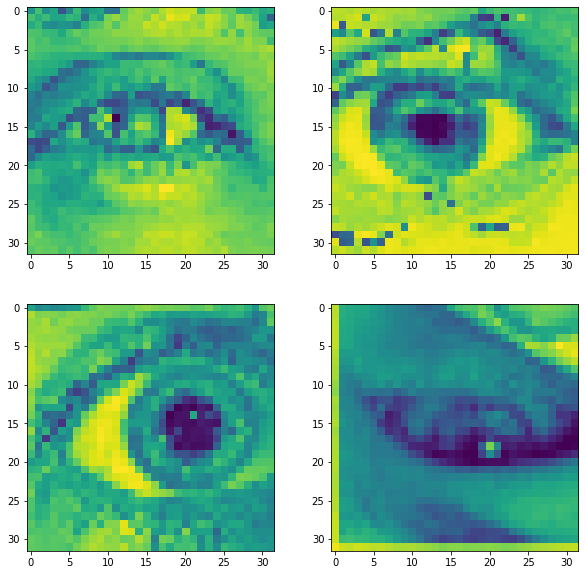

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_image[i][:,:,0])
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten ,ZeroPadding2D
from tensorflow.keras.models import Model
from keras.regularizers import l2

In [ ]:
losse=tf.keras.losses.CategoricalCrossentropy(
    name='categorical_crossentropy'
)
from tensorflow.keras.optimizers import Adadelta,Adam
es=keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=5)


#build the models 
we tried to build diffents model to train in our collected dataset . to make sure get must impressive accuaray from our exprimenet . 
since that data isn't distrubt from expert poeple we wil expect to get as possible more the 80% at fisrt time . 

In [ ]:
# # build the model by supplying inputs/outputs

In [ ]:
#plot to create stylized diagnostic plot for presentation
def accuracy_plot(history, filename):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title('Classification Accuracy Convolution Neural Network', fontweight='bold', fontsize=20, loc='left')
    ax.plot(history.history['accuracy'], color='#696c70', label='train', linewidth=2.5)
    ax.plot(history.history['val_accuracy'], color='#397ad4', label='Val', linewidth=2.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Training Epoch', fontsize=15)
    
    plt.savefig(filename + '_plot.png')
    
    plt.legend()

1.function to show the performence the model 

In [ ]:
import os
from os import listdir
import sys
import numpy as np
from numpy import asarray
from numpy import save
import matplotlib.pyplot as plt
from tensorflow import keras


import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Input, InputLayer, Dropout
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

import random
import shutil

#model convolution and linear 


In [ ]:
IMAGE_SIZE=32
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3
#fourth_filters=256

dropout_conv = 0.3
dropout_dense = 0.3


In [ ]:
to_file="/drive/My Drive/Fouzia/results/"
def train_top_model():
################# fisrt modole builinf block on CNN #################################  

      model = Sequential()
      model.add(Conv2D(first_filters, kernel_size, activation = 'relu',input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
      model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
      model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
      model.add(MaxPooling2D(pool_size = pool_size)) 
      model.add(Dropout(dropout_conv))

      # model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
      # model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
      # model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
      # model.add(MaxPooling2D(pool_size = pool_size))
      # model.add(Dropout(dropout_conv))

      # model.add(Flatten())
      # model.add(Dense(256, activation = "relu"))
      # model.add(Dropout(dropout_dense))

      model.add(Dense(5, activation = "softmax"))

#####################change activition function################################

################### Second model linear wthout CNN layers######################       
     
      # model = Sequential()
      # model.add(Flatten(input_shape=input_shape))
      # model.add(Dense(256, activation='relu'))
      # model.add(Dropout(0.2))
      # model.add(Dense(128, activation='relu'))
      # model.add(Dropout(0.5))
      # model.add(Dense(64, activation='relu'))
      # model.add(Dropout(0.6))
      # model.add(Dense(len(num_labels), activation='softmax'))

################################################################################
################################################################################
      plot_model(
      model,
      to_file="/drive/My Drive/Fouzia/results/Detecting_Signs_ARCH.png",
      show_shapes=True,
      show_dtype=True,
      show_layer_names=True,
      rankdir="TB",
      show_layer_activations=True,
      )

      opt = SGD(lr=0.001, momentum=0.9)
      model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

      checkpoint_filepath = '/drive/My Drive/Fouzia/results/check_wieghts/weights-{epoch:02d}-{val_accuracy:.3f}.hdf5'

      model_checkpoint_callback = ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True,
      verbose=1
      )

      history = model.fit(X_train, y_train,
            epochs=400,
            batch_size=32,
            validation_split=0.2,
            callbacks=[model_checkpoint_callback])
      model.save('/drive/My Drive/Fouzia/results/bottleneck_fully_connected_model.h5')

      # learning curves
      accuracy_plot(history,to_file)
      return model

Epoch 1/400


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 9/10 [==========================>...] - ETA: 0s - loss: 1.6070 - accuracy: 0.2326
Epoch 1: val_accuracy improved from -inf to 0.31250, saving model to /drive/My Drive/Fouzia/results/check_wieghts/weights-01-0.312.hdf5
10/10 [==============================] - 2s 88ms/step - loss: 1.6067 - accuracy: 0.2366 - val_loss: 1.6049 - val_accuracy: 0.3125
Epoch 2/400
 9/10 [==========================>...] - ETA: 0s - loss: 1.6000 - accuracy: 0.3125
Epoch 2: val_accuracy did not improve from 0.31250
10/10 [==============================] - 0s 19ms/step - loss: 1.5988 - accuracy: 0.3249 - val_loss: 1.5985 - val_accuracy: 0.3125
Epoch 3/400
 9/10 [==========================>...] - ETA: 0s - loss: 1.5892 - accuracy: 0.3542
Epoch 3: val_accuracy did not improve from 0.31250
10/10 [==============================] - 0s 19ms/step - loss: 1.5899 - accuracy: 0.3438 - val_loss: 1.5912 - val_accuracy: 0.3125
Epoch 4/400
 9/10 [==========================>...] - ETA: 0s - loss: 1.5801 - accuracy: 0.3611
Epoc

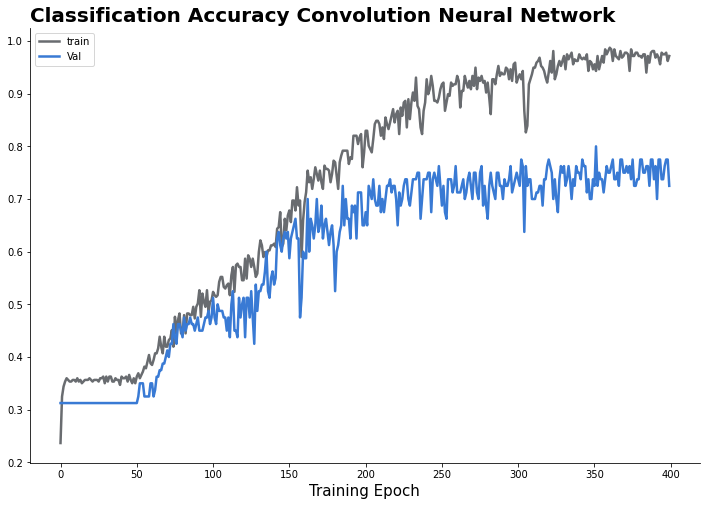

In [ ]:
output=train_top_model()
output

# model evidence for low data distrubtion isn't enough to training the model , and we i will got underfitting case 

In [ ]:
# network parameters
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
filters_1 = 32
filters_2 = 64
filters_3 = 128
filters_4= 256

dropout = 0.3

In [ ]:
# ## use functional API to build cnn layers
# inputs = Input(shape=input_shape)
# augmented = data_augmentation(inputs)

# y = Conv2D(filters=filters_1,kernel_size= kernel_size,activation='relu')(augmented)
# y = ZeroPadding2D(padding=(1,1))(y)

# y = Conv2D(filters=filters_1,kernel_size=kernel_size, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(y)
# y = MaxPooling2D(pool_size=(2,2))(y)

# y = Conv2D(filters=filters_2,kernel_size=kernel_size,activation='relu')(y)
# y = ZeroPadding2D(padding=(1,1))(y)
# y = Dropout(dropout)(y) 


# y = Conv2D(filters=filters_2,kernel_size=kernel_size, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(y)
# y = MaxPooling2D(pool_size=(2,2))(y)
# y = BatchNormalization()(y)

# y = Conv2D(filters=filters_3,kernel_size=kernel_size,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(y)
# y = ZeroPadding2D(padding=(1,1))(y)



# y = Conv2D(filters=filters_3,kernel_size=kernel_size,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(y)
# y = MaxPooling2D(pool_size=(2,2))(y)
# y = Dropout(dropout)(y)

# #y = Conv2D(filters=filters_4,kernel_size=kernel_size,activation='relu')(y)
# #y = MaxPooling2D(pool_size=(2,2))(y)
# #y = BatchNormalization()(y)

# #y = Conv2D(filters=filters_4, kernel_size=kernel_size,activation='relu')(y)
# # image to vector before connecting to dense layer
# y = Flatten()(y)
# y = Dense(300, activation='relu')(y)
# y = Dropout(dropout)(y)
# outputs = Dense(len(num_labels), activation='softmax')(y)

In [ ]:
# from matplotlib.colors import NoNorm
# #stop = EarlyStopping(monitor = 'loss', patience = 2, verbose = 2, mode = 'auto')


# losse=tf.keras.losses.CategoricalCrossentropy(
#       label_smoothing=0.1,
#        name='categorical_crossentropy'
# )

# model.save("/drive/My Drive/Fouzia/results/Detecting_Signs_saved_weights_2.h5",
#              save_traces=True,
#             include_optimizer=True
# )


# model.compile(
#     optimizer="adam",
#     loss=losse,
#     metrics=["accuracy"],
# )
# history =model.fit(X_train, y_train, epochs=300,verbose=1,validation_split=0.2,batch_size=16)


# the technic of tuning-Hyper-parameters of loop to find best parameters in CNN 

In [ ]:
# import time
# dense_layers = [0, 1, 2]
# layer_sizes = [32, 64, 128]
# conv_layers = [1, 2, 3]

# for dense_layer in dense_layers:
#     for layer_size in layer_sizes:
#         for conv_layer in conv_layers:
#             NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
#             print(NAME)

#             model = Sequential()

#             model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
#             model.add(Activation('relu'))
#             model.add(MaxPooling2D(pool_size=(2, 2)))

#             for l in range(conv_layer-1):
#                 model.add(Conv2D(layer_size, (3, 3)))
#                 model.add(Activation('relu'))
#                 model.add(MaxPooling2D(pool_size=(2, 2)))

#             model.add(Flatten())

#             for _ in range(dense_layer):
#                 model.add(Dense(layer_size))
#                 model.add(Activation('relu'))

#             model.add(Dense(len(num_labels)))
#             model.add(Activation('softmax'))

            
#             #es=keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=5)

#             model.compile(loss='categorical_crossentropy',
#                           optimizer='adam',
#                           metrics=['accuracy'],
#                           )

#             history =model.fit(X_train, y_train,
#                                epochs=70,verbose=1,
#                                validation_split=0.2,
#                                batch_size=128
#                                )

              #accuracy_plot(history,to_file)   

# Analysis the Perfomence Model 
* training / Loss function plots 
* classification report 
* confusing Matrix 

In [ ]:
output.metrics_names

['loss', 'accuracy']

In [ ]:
val_loss, val_accuracy = \
evaluate=output.evaluate(X_test, y_test,batch_size=128)
print('Vall_loss:', val_loss)
print('val_acc:', val_accuracy)

1/1 [==============================] - 0s 182ms/step - loss: 1.2250 - accuracy: 0.7600
Vall_loss: 1.2249765396118164
val_acc: 0.7599999904632568


In [ ]:
predictions=np.argmax(output.predict(X_test), axis=-1)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
num_labels=['normal_eye', 'stye_eye', 'jaundice_eye', 'uveitis_eye', 'pink_eye']
print("[INFO] evaluating network...")
predictions = output.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=-1),
  predictions.argmax(axis=-1), target_names=num_labels))

[INFO] evaluating network...
              precision    recall  f1-score   support

  normal_eye       0.81      0.88      0.84        24
    stye_eye       0.76      0.70      0.73        27
jaundice_eye       1.00      0.64      0.78        11
 uveitis_eye       0.67      0.83      0.74        29
    pink_eye       0.83      0.56      0.67         9

    accuracy                           0.76       100
   macro avg       0.81      0.72      0.75       100
weighted avg       0.78      0.76      0.76       100



In [ ]:
import pandas as pd
path_report='/drive/My Drive/Fouzia/results/classification_report_GMD_0_Nor64.csv'
from sklearn.metrics import classification_report
from collections import defaultdict

num_labels=['normal_eye', 'stye_eye', 'jaundice_eye', 'uveitis_eye', 'pink_eye']
import pandas as pd
import sklearn.metrics
import numpy as np

def classification_report(*args, **kwargs):
    out_df = pd.DataFrame(sklearn.metrics.classification_report(*args, **kwargs, output_dict=True)).T
    # Order cols
    out_df[["precision","recall","f1-score","support"]]  
    # Round
    out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
    out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    # Add suport to avg
    out_df.loc['accuracy', 'support'] = out_df.loc['weighted avg', 'support']
    return out_df

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
num_labels=['normal_eye', 'stye_eye', 'jaundice_eye', 'uveitis_eye', 'pink_eye']
print("[INFO] evaluating network...")
predictions = output.predict(X_test, batch_size=128)
out_df=pd.DataFrame(classification_report(y_test.argmax(axis=-1),predictions.argmax(axis=-1), 
                                          target_names=num_labels,output_dict=True)).T

# Order cols
out_df[["precision","recall","f1-score","support"]]  
    # Round
out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    # Add suport to avg
out_df.loc['accuracy', 'support'] = out_df.loc['weighted avg', 'support']
out_df.to_csv(path_report, index = True)

[INFO] evaluating network...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
out_df.head()

,precision,recall,f1-score,support
normal_eye,0.81,0.88,0.84,24
stye_eye,0.76,0.70,0.73,27
jaundice_eye,1.00,0.64,0.78,11
uveitis_eye,0.67,0.83,0.74,29
pink_eye,0.83,0.56,0.67,9


In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
import os
import sys
p = Augmentor.Pipeline("/drive/My Drive/Fouzia/dataset/train/augment_images")

p.random_distortion(probability=0.1, grid_width=4, grid_height=4, magnitude=8)
# First, we add a horizontal flip operation to the pipeline:
p.flip_left_right(probability=0.4)

# Now we add a vertical flip operation to the pipeline:
p.flip_top_bottom(probability=0.8)

# Add a rotate90 operation to the pipeline:
p.rotate90(probability=0.1)

p.zoom(probability=0.002, min_factor=1.1, max_factor=1.5)

p.resize(probability=1,width=512, height=512)

p.sample(120)


p.status()


Initialised with 497 image(s) found.
Output directory set to /drive/My Drive/Fouzia/dataset/train/augment_images/output.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7FE35DB15B10>: 100%|██████████| 120/120 [00:04<00:00, 25.10 Samples/s]


Operations: 6
	0: Distort (probability=0.1 grid_width=4 grid_height=4 magnitude=8 randomise_magnitude=True )
	1: Flip (probability=0.4 top_bottom_left_right=LEFT_RIGHT )
	2: Flip (probability=0.8 top_bottom_left_right=TOP_BOTTOM )
	3: Rotate 90 (probability=0.1 rotation=90 )
	4: Zoom (probability=0.002 min_factor=1.1 max_factor=1.5 )
	5: Resize (probability=1 width=512 height=512 resample_filter=BICUBIC )
Images: 497
Classes: 5
	Class index: 0 Class label: jaundice_eye 
	Class index: 1 Class label: normal_eye 
	Class index: 2 Class label: pink_eye 
	Class index: 3 Class label: stye_eye 
	Class index: 4 Class label: uveitis_eye 
Dimensions: 140
	Width: 53 Height: 53
	Width: 267 Height: 267
	Width: 58 Height: 58
	Width: 211 Height: 211
	Width: 268 Height: 268
	Width: 645 Height: 645
	Width: 251 Height: 251
	Width: 66 Height: 66
	Width: 206 Height: 206
	Width: 190 Height: 190
	Width: 306 Height: 306
	Width: 257 Height: 257
	Width: 166 Height: 166
	Width: 90 Height: 90
	Width: 550 Height: 

In [ ]:
val_image_gen = ImageDataGenerator(rescale = 1./255)
BATCH_SIZE=128
PLOTS_DPI = 200
image_size=32
IMG_SHAPE= (image_size, image_size)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# in this section generating test random data 

Found 120 images belonging to 5 classes.
 0 : jaundice_eye
 1 : normal_eye
 2 : pink_eye
 3 : stye_eye
 4 : uveitis_eye


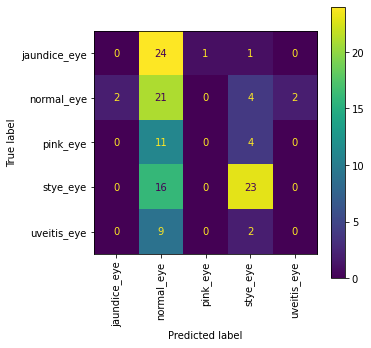

In [ ]:
Test_DIR="/drive/My Drive/Fouzia/dataset/test/test"
evaluation_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = Test_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )
class_name_lookup = {name: index for index, name in evaluation_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")
val_true = evaluation_data_gen.classes
val_pred = np.argmax(output.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (5, 5))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('/drive/My Drive/Fouzia/results/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()


# Prediction Outputs using Validation data generated 

In [ ]:
from keras.preprocessing import image
path='/drive/My Drive/Fouzia/dataset/test/pink_eye/pink_eye.jpg'
def get_img_array(img_path, size):
    # `img` is a PIL image of size 64x64
    #img =image.load_img(img_path, target_size=(size,size,3))
    src = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    resized=cv2.resize(src,(size,size))
    # `array` is a float32 Numpy array of shape (64,64, 3)
    img =image.img_to_array(resized)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 64, 64, 3)
    img = img/255
    #img=img.reshape(1,size,size,3)
    return img
image=get_img_array(path,32)    

In [ ]:
from tensorflow import keras
path_model='/drive/My Drive/results/bottleneck_fully_connected_model.h5'
model = keras.models.load_model(path_model)

In [ ]:
#classes= np.array((df_data.columns[2:]))
num_labels=['normal_eye', 'stye_eye', 'jaundice_eye', 'uveitis_eye', 'pink_eye']

#print(classes[0:])
Sitution_Medical={'Normal':' you are healthy no probelm adressed in your sitution',
                  'Stey' :'consider this sitution \n  you have ,A person with a stye will have a painful red swelling on the eyelid,\n making the eye produce tears and become red. Often the lump looks like a boil  ',
                  'jaundice':'The whites of your eyes (called the sclera) turn yellow when you have a condition called jaundice. \nThe whites of your eyes might turn yellow when your body has too much of \n a chemical called bilirubin, a yellow substance that forms when red blood cells break down',
                  'uveitis':'Uveitis can cause problems like pain, redness, and vision loss. \n Uveitis damages the part of the eye called the uvea — but it often affects other parts of the eye,\n too. Sometimes uveitis goes away quickly, but it can come back.',
                  'Pink':'Pink eye (conjunctivitis) is the inflammation or infection of the transparent membrane that lines your eyelid and eyeball '
}
print(Sitution_Medical.get('Pink'))

Pink eye (conjunctivitis) is the inflammation or infection of the transparent membrane that lines your eyelid and eyeball 


#Prediction of medical situation from external eye facial features
1. here we will provide the medical situation may patient have based on prediction and expert doctors's talks with their recommend case should patient take away seriously
2. Cases \\
Stye : https://www.medicalnewstoday.com/articles/220551#consulting-a-doctor \\
Jaundice : https://www.webmd.com/a-to-z-guides/causes-of-yellow-eyes#:~:text=The%20whites%20of%20your%20eyes,red%20blood%20cells%20break%20down \\
Uveitits : https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/uveitis#:~:text=Uveitis%20can%20cause%20problems%20like,(long%2Dterm)%20condition. \\
Pink : https://www.mayoclinic.org/diseases-conditions/pink-eye/symptoms-causes/syc-20376355#:~:text=Pink%20eye%20(conjunctivitis)%20is%20the,your%20eyelashes%20during%20the%20night.

 you are healthy no probelm adressed in your sitution


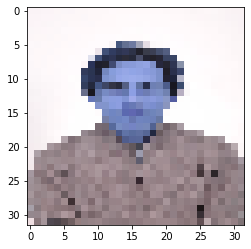

<Figure size 720x432 with 0 Axes>

In [ ]:
classes= ['normal_eye', 'stye_eye', 'jaundice_eye', 'uveitis_eye', 'pink_eye']

# def prepare(filepath,size):
# 	IMG_SIZE =32
# 	img_array = cv2.imread(filepath)
# 	new_array = cv2.resize(img_array,(size,size))
# 	return new_array.reshape(1,IMG_SIZE,IMG_SIZE,3)
proba = model.predict(image.reshape(1,32,32,3))
#top_2 = np.argsort(proba[0])[:-4:-1]
#proba = output.predict(image.reshape(1,32,32,3))

top_2 = np.argsort(proba[0],kind ='heapsort', axis = -1)[:-5:-1]
for j in range(1):
		if classes[top_2[j]] == classes[0]:
			print("{}".format(classes[top_2[j]])+" ({:.2%})".format(proba[0][top_2[j]]))
			print(Sitution_Medical.get('jaundice'))
		elif classes[top_2[j]]== classes[2]:
			print("{}".format(classes[top_2[j]])+" ({:.2%})".format(proba[0][top_2[j]]))
			print(Sitution_Medical.get('Pink'))
		elif classes[top_2[j]]== classes[3]:
			print("{}".format(classes[top_2[j]])+" ({:.2%})".format(proba[0][top_2[j]]))
			print(Sitution_Medical.get('Stey'))  
		elif classes[top_2[j]] == classes[4]:
			print("{}".format(classes[top_2[j]])+" ({:.2%})".format(proba[0][top_2[j]]))
			print(Sitution_Medical.get('uveitis')) 
		else:
			print(Sitution_Medical.get('Normal'))
		plt.imshow(image)
		plt.figure(figsize=(10,6)) 